# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [64]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as sci
from scipy.stats import linregress
from pprint import pprint
from config import weather_api_key, gkey
from citipy import citipy
from datetime import datetime
import os
import csv

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

622

In [4]:
# To make the DataFrame look cleaner, convert the cities list to titlecase
cities_list = []
for city in cities: 
    cities_list.append(city.title())
    
len(cities_list)

622

In [5]:
# Create the Empty DataFrame for the API Calls: Columns == Temperature, Humidity, Cloudiness, Windspeed

cities_df = pd.DataFrame(cities_list)
cities_df = cities_df.rename(columns={0: "City"})
cities_df["Lat"] = ""
cities_df["Lng"] = ""
cities_df["Date and Time"] = ""
cities_df["Max Temperature"] = ""
cities_df["Humidity"] = ""
cities_df["Cloudiness"] = ""
cities_df["Windspeed"] = ""
cities_df

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Punta Arenas,,,,,,,
1,Tura,,,,,,,
2,Ushuaia,,,,,,,
3,Cherskiy,,,,,,,
4,Vostok,,,,,,,
...,...,...,...,...,...,...,...,...
617,Andenes,,,,,,,
618,Ucluelet,,,,,,,
619,Sterling,,,,,,,
620,Charters Towers,,,,,,,


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
# # Test DataFrame and API Calls

# # This is the test code I used to limit my API calls while troubleshooting 

# base_weather_url = "http://api.openweathermap.org/data/2.5/weather?q="

# # test city
# city_test = ["Punta Arenas"]
# cities_test_df = pd.DataFrame(city_test)
# cities_test_df = cities_test_df.rename(columns={0: "City"})
# cities_test_df["Max Temperature"] = ""
# cities_test_df["Humidity"] = ""
# cities_test_df["Cloudiness"] = ""
# cities_test_df["Windspeed"] = ""
# cities_test_df

# for index, row in cities_test_df.iterrows():
#     time.sleep(1)
#     city = row["City"]
#     get_weather_url = base_weather_url + f"{city}&appid={weather_api_key}&units=imperial"
#     weather_request = requests.get(get_weather_url).json()
#     date_time = weather_request["dt"]
#     date_time_converted = (datetime.utcfromtimestamp(date_time).strftime('%Y-%m-%d %H:%M:%S'))
#     temp = weather_request["main"]["temp_max"]
#     humid = weather_request["main"]["humidity"]
#     cloud = weather_request["clouds"]["all"]
#     wind = weather_request["wind"]["speed"]
#     lat = weather_request["coord"]["lat"]
#     lng = weather_request["coord"]["lon"]
#     pprint(weather_request)
    
#     cities_test_df.loc[index, "Date and Time"] = date_time_converted
#     cities_test_df.loc[index, "Lat"] = lat
#     cities_test_df.loc[index, "Lng"] = lng
#     cities_test_df.loc[index, "Max Temperature"] = temp
#     cities_test_df.loc[index, "Humidity"] = humid
#     cities_test_df.loc[index, "Cloudiness"] = cloud
#     cities_test_df.loc[index, "Windspeed"] = wind
# cities_test_df

In [7]:
# Set the base ULR 
base_weather_url = "http://api.openweathermap.org/data/2.5/weather?q="

# Display empty DataFrame, just as a reminder
cities_df

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Punta Arenas,,,,,,,
1,Tura,,,,,,,
2,Ushuaia,,,,,,,
3,Cherskiy,,,,,,,
4,Vostok,,,,,,,
...,...,...,...,...,...,...,...,...
617,Andenes,,,,,,,
618,Ucluelet,,,,,,,
619,Sterling,,,,,,,
620,Charters Towers,,,,,,,


In [105]:
# Iterrate through rows and collect data

call_number = 1

for index, row in cities_df.iterrows():
    
    # Set time.sleep to 1 so that it makes a call every second - API max calls is 60 per minute
    time.sleep(1)
    
    # Get variable value to work with based on the row
    city = row["City"]
    
    # Create the URL with the new value and make API call
    get_weather_url = base_weather_url + f"{city}&appid={weather_api_key}&units=imperial"
    weather_request = requests.get(get_weather_url).json()
    
    # Create try, since not all data will be find for all cities
    try:
        # Get the date and time, then convert from UTC
        date_time = weather_request["dt"]
        
        # Convert unix date/time. Note: This was found on StackExchange: https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date
        date_time_converted = (datetime.utcfromtimestamp(date_time).strftime('%Y-%m-%d %H:%M:%S'))
        
        # Grab data from JSON and assign to variable; 
        # note, this does not need to be done here, could be done with .loc statements

        temp = weather_request["main"]["temp_max"]
        humid = weather_request["main"]["humidity"]
        cloud = weather_request["clouds"]["all"]
        wind = weather_request["wind"]["speed"]
        lat = weather_request["coord"]["lat"]
        lng = weather_request["coord"]["lon"]
        
        # If it works, print call number and city success statement
        print(f"Call #{call_number}: {city} success.")
        
    # KeyError comes back when the ["main"] is not found with call number
    except KeyError:
        print(f"Call #{call_number}: Data not found for {city}.")
        pass
    
    # Add 1 to call_number
    call_number += 1
    
    #Fill in data for each index/City in dataframe
    cities_df.loc[index, "Date and Time"] = date_time_converted    
    cities_df.loc[index, "Lat"] = lat
    cities_df.loc[index, "Lng"] = lng    
    cities_df.loc[index, "Max Temperature"] = temp
    cities_df.loc[index, "Humidity"] = humid
    cities_df.loc[index, "Cloudiness"] = cloud
    cities_df.loc[index, "Windspeed"] = wind

Call #1: Punta Arenas success.
Call #2: Tura success.
Call #3: Ushuaia success.
Call #4: Cherskiy success.
Call #5: Vostok success.
Call #6: Asau success.
Call #7: Balmedie success.
Call #8: Thompson success.
Call #9: Makakilo City success.
Call #10: Georgetown success.
Call #11: Saint-Francois success.
Call #12: Karratha success.
Call #13: Kapaa success.
Call #14: Data not found for Taolanaro.
Call #15: Havre-Saint-Pierre success.
Call #16: Tuatapere success.
Call #17: New Cumnock success.
Call #18: Conceicao Do Araguaia success.
Call #19: Vaini success.
Call #20: Rikitea success.
Call #21: Albany success.
Call #22: Kutum success.
Call #23: Kiunga success.
Call #24: Hami success.
Call #25: Kamennogorsk success.
Call #26: Severo-Kurilsk success.
Call #27: Entre Rios success.
Call #28: Acapulco success.
Call #29: Hobyo success.
Call #30: Hermanus success.
Call #31: Srandakan success.
Call #32: Annonay success.
Call #33: Saint George success.
Call #34: Honiara success.
Call #35: Nelson B

Call #273: Cedar City success.
Call #274: Fortuna success.
Call #275: Pisco success.
Call #276: Anuradhapura success.
Call #277: San Patricio success.
Call #278: Semey success.
Call #279: Longyearbyen success.
Call #280: Bambanglipuro success.
Call #281: Zeya success.
Call #282: Shiyan success.
Call #283: Stornoway success.
Call #284: Alofi success.
Call #285: Norman Wells success.
Call #286: Nouadhibou success.
Call #287: Hamilton success.
Call #288: Ossora success.
Call #289: Chapais success.
Call #290: Kaeo success.
Call #291: Zhuhai success.
Call #292: Nizhnevartovsk success.
Call #293: Data not found for Paradwip.
Call #294: Saskylakh success.
Call #295: Grimshaw success.
Call #296: Orcopampa success.
Call #297: Mumford success.
Call #298: Honningsvag success.
Call #299: Faanui success.
Call #300: Coquimbo success.
Call #301: Katobu success.
Call #302: Benjamin Hill success.
Call #303: Formosa success.
Call #304: Anadyr success.
Call #305: West Point success.
Call #306: Kharan suc

Call #546: Nome success.
Call #547: Yar-Sale success.
Call #548: Tomatlan success.
Call #549: Tyrma success.
Call #550: Arman success.
Call #551: Inowroclaw success.
Call #552: Caraballeda success.
Call #553: Data not found for Tabialan.
Call #554: Duluth success.
Call #555: Laela success.
Call #556: Honggang success.
Call #557: Wilmington success.
Call #558: Baiquan success.
Call #559: Dekar success.
Call #560: Nyahururu success.
Call #561: Ballina success.
Call #562: Osakarovka success.
Call #563: Naryan-Mar success.
Call #564: Parainen success.
Call #565: Finschhafen success.
Call #566: Baculin success.
Call #567: Mbandaka success.
Call #568: Paredon success.
Call #569: Data not found for Inderborskiy.
Call #570: Arak success.
Call #571: Koslan success.
Call #572: Waitati success.
Call #573: Abnub success.
Call #574: Saint Anthony success.
Call #575: Rabo De Peixe success.
Call #576: Data not found for Marcona.
Call #577: Chara success.
Call #578: Mikuni success.
Call #579: Menongue

In [12]:
cities_df

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Punta Arenas,-53.15,-70.92,2020-10-21 14:34:10,46.4,49,90,17.22
1,Tura,25.52,90.22,2020-10-21 14:34:11,72.16,93,0,2.91
2,Ushuaia,-54.8,-68.3,2020-10-21 14:34:12,48.2,42,90,23.04
3,Cherskiy,68.75,161.3,2020-10-21 14:34:13,16.18,97,79,3.09
4,Vostok,46.49,135.88,2020-10-21 14:34:14,41.13,94,100,6.26
...,...,...,...,...,...,...,...,...
617,Andenes,69.31,16.12,2020-10-21 14:46:37,35.6,59,20,13.87
618,Ucluelet,48.93,-125.55,2020-10-21 14:46:38,44.6,87,5,5.82
619,Sterling,39.01,-77.43,2020-10-21 14:43:25,66,100,90,10.29
620,Charters Towers,-20.1,146.27,2020-10-21 14:46:40,68.47,88,2,10.22


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

**Note**: The to_csv was created with my first call to the API to get data for the rest of the project, it is commented out here so as not to overwrite the CSV I wanted to work with.

In [178]:
# cities_df.to_csv("../output_data/api-data.csv")

### Working with CSV (10-20-2020 Data)

In [111]:
# Create the CSV Path and Read the CSV
# Note, I like using os.path.join, though there are other ways to do this

csv_path = os.path.join("..", "output_data", "api-data.csv")
weather_df = pd.read_csv(csv_path)

# I noticed it creates an "index" column next to the index, repeating the same values
# so I dropped that since we already have the index

weather_df = weather_df.drop(columns="Unnamed: 0")
weather_df

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Kapaa,22.08,-159.32,2020-10-20 16:55:17,73.00,79,46,8.55
1,Cheuskiny,22.08,-159.32,2020-10-20 16:55:17,73.00,79,46,8.55
2,Belmonte,-15.86,-38.88,2020-10-20 16:55:26,77.00,83,90,6.93
3,Port Elizabeth,-33.92,25.57,2020-10-20 16:53:30,62.60,72,10,19.46
4,Norman Wells,65.28,-126.83,2020-10-20 16:55:32,17.60,92,75,9.17
...,...,...,...,...,...,...,...,...
574,Samusu,-16.23,39.91,2020-10-20 17:08:12,78.96,72,0,10.94
575,Jubayl,-16.23,39.91,2020-10-20 17:08:12,78.96,72,0,10.94
576,Leshukonskoye,64.90,45.76,2020-10-20 17:01:03,25.41,98,88,6.13
577,Bonavista,48.65,-53.11,2020-10-20 17:03:17,55.24,81,99,14.27


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [112]:
# Check to see if any cities have a humidity over 100%
gt100_humid = weather_df.loc[weather_df["Humidity"] > 100].count()
gt100_humid

City               0
Lat                0
Lng                0
Date and Time      0
Max Temperature    0
Humidity           0
Cloudiness         0
Windspeed          0
dtype: int64

In [113]:
#  No humidities over 100%.

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

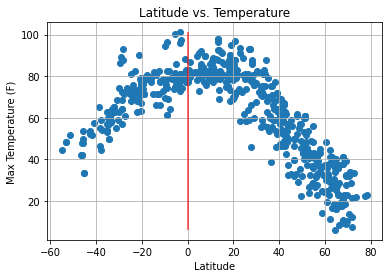

In [114]:
# Find and set the data to work with: Latitude and Max Temperature
lat_scatter = weather_df["Lat"]
temp_scatter = weather_df["Max Temperature"]

# Set the Labels for the Title, X-Axis, and Y-Axis
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")
plt.title("Latitude vs. Temperature")

# Add horizontal line for the "equator" and a grid to make it easier to read
plt.vlines(0, min(temp_scatter), max(temp_scatter), alpha=.75, color="red")
plt.grid()

# Populate and save the figure / plot
plt.scatter(lat_scatter, temp_scatter)
plt.savefig("../output_data/lat_vs_temp_fig.jpeg")

### About Latitude vs. Temperature Scatter Plot

The above plot looks at the Max Temperature as taken on the date the data was pulled from the OpenWeather API: Date, 10-20-2020. Along with the Max Temperature is the latitude of each city in the `weather_df` dataframe. "0" on the x-axis is the equater (represented by the green vertical line).

The scatter plot was used since there were multiple data points that were not categorical (ruling out bar/pie) and the data were not a time-series (since they were pulled at a specific point in time rather than over several points in time). 

#### Observations
* As the temperature increases, the points move closer to the equator (i.e., Lat = 0)
    * That being said, it favors positive latitude a bit right now (northern hemisphere), and it would be interesting to see if the change in jet streams and the earth's wobble / axis tilt change this data over time where we would see the warmest temperatures fluxuate between -20 and 20 degrees latitude.

## Latitude vs. Humidity Plot

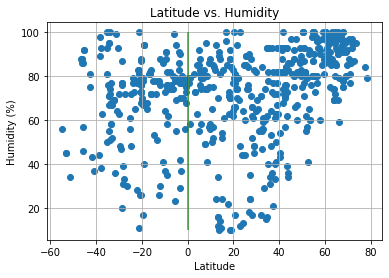

In [158]:
# Find and set the data to work with: Humidity and Latitude
lat_scatter = weather_df["Lat"]
humid_scatter = weather_df["Humidity"]

# Set the Labels for the Title, X-Axis, and Y-Axis
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.title("Latitude vs. Humidity")

# Add horizontal line for the "equator" and a grid to make it easier to read
plt.vlines(0, min(humid_scatter), max(humid_scatter), alpha=.75, color="green")
plt.grid()

# Populate and save the figure / plot
plt.scatter(lat_scatter, humid_scatter)
plt.savefig("../output_data/lat_vs_humid_fig.jpeg")

In [159]:
lat_greater_50 = weather_df.loc[weather_df["Lat"] >= 50]
lat_greater_50 = lat_greater_50.reset_index()
lat_greater_50 = lat_greater_50.drop(columns={"index"})
lat_greater_50

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Norman Wells,65.28,-126.83,2020-10-20 16:55:32,17.60,92,75,9.17
1,Grindavik,63.84,-22.43,2020-10-20 16:52:58,39.20,69,75,6.93
2,Longyearbyen,78.22,15.64,2020-10-20 16:55:45,23.00,79,41,3.36
3,Ilulissat,69.22,-51.10,2020-10-20 16:55:47,39.20,80,75,12.75
4,Severo-Kurilsk,50.68,156.12,2020-10-20 16:55:53,40.01,71,30,24.40
...,...,...,...,...,...,...,...,...
137,Belyy Yar,53.60,91.39,2020-10-20 17:07:51,42.80,60,80,4.47
138,Chunskiy,56.08,99.63,2020-10-20 17:07:57,31.68,98,100,6.26
139,Gubkinskiy,64.43,76.50,2020-10-20 17:08:03,28.09,97,100,6.87
140,Verkhnyaya Toyma,62.23,45.00,2020-10-20 17:08:09,29.05,97,100,7.45


### About Latitude vs. Humidity Scatter

Using the same functions as the first scatter, this one simply swaps out the temperature variable for humidity. 

#### Observations
* As of pulling the data, there is a cluster of values above 50 degrees latitude that I wanted to look at. Sampling just a few (Chunskiy, Verkhnyaya Toyma, Gubkinskiy), they were all in Russia. 
* By the eye, it looks as though for this sampling most of the humidity is in the northern hemisphere. This will be checked later with linear regression for correlation. 

## Latitude vs. Cloudiness Plot

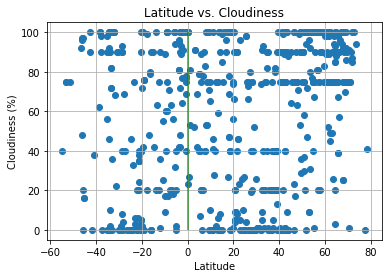

In [160]:
# Find and set the data to work with: Cloudiness and Latitude
lat_scatter = weather_df["Lat"]
cloud_scatter = weather_df["Cloudiness"]

# Set the Labels for the Title, X-Axis, and Y-Axis
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.title("Latitude vs. Cloudiness")

# Add horizontal line for the "equator" and a grid to make it easier to read
plt.vlines(0, min(cloud_scatter), max(cloud_scatter), alpha=.75, color="green")
plt.grid()

# Populate and save the figure / plot
plt.scatter(lat_scatter, cloud_scatter)
plt.savefig("../output_data/lat_vs_cloud_fig.jpeg")

### Observations - Latitude vs. Cloudiness Scatter Plot
* Again, there doesn't seem to be any correlation between latitude and cloudiness, though we do have more datapoints in the northern hemisphere. This will be checked with linear regression, but it's quite possible that our random sampling pulled more values for the northern hemisphere than the southern. 

Actually, let's check that right now: 

In [161]:
count_northern = weather_df.loc[weather_df["Lat"] > 0].count().unique()
count_southern = weather_df.loc[weather_df["Lat"] < 0].count().unique()
hemisphere_data_counts = pd.DataFrame({"Count Northern": count_northern, "Count Southern": count_southern})
hemisphere_data_counts

,Count Northern,Count Southern
0,393,186


* It looks like we do have a little over double the count of northern hemisphere datapoints than we do southern. This should be kept in mind when analyzing the data. 

## Latitude vs. Wind Speed Plot

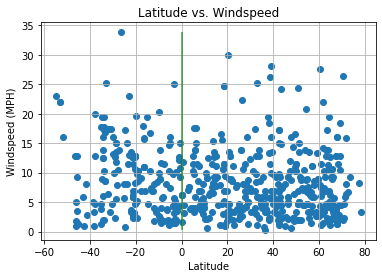

In [162]:
# Find and set the data to work with: Cloudiness and Latitude
lat_scatter = weather_df["Lat"]
wind_scatter = weather_df["Windspeed"]

# Set the Labels for the Title, X-Axis, and Y-Axis
plt.ylabel("Windspeed (MPH)")
plt.xlabel("Latitude")
plt.title("Latitude vs. Windspeed")

# Add horizontal line for the "equator" and a grid to make it easier to read
plt.vlines(0, min(wind_scatter), max(wind_scatter), alpha=.75, color="green")
plt.grid()

# Populate and save the figure / plot
plt.scatter(lat_scatter, wind_scatter)
plt.savefig("../output_data/lat_vs_wind_fig.jpeg")

#### Observations: Latitude vs. Windspeed

Again, there doesn't seem to be any correlation (looking at it without linear regression), but this this will be checked later in this project.

# Linear Regression

## Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation (r) of temperature to latitude is: -0.9009888253141172.


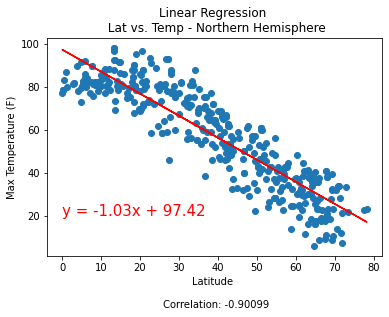

In [163]:
# Grab all Northern Hemisphere (NH) Data to work with
northern_hem_df = weather_df.loc[weather_df["Lat"] > 0]

# Set NH varibales
nh_temp = northern_hem_df["Max Temperature"]
nh_lat = northern_hem_df["Lat"]

# Calc linear regression and create string for annotation
(slope, intercept, rvalue, pvalue, stderr) = linregress(nh_lat, nh_temp)
nh_temp_lat_regress_values = nh_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Create and label the scatter plot
plt.scatter(nh_lat,nh_temp)
plt.title("Linear Regression \n Lat vs. Temp - Northern Hemisphere")
plt.ylabel("Max Temperature (F)")
plt.xlabel(f"Latitude \n \n Correlation: {round(nh_temp_lat_co, 5)}")
plt.plot(nh_lat,nh_temp_lat_regress_values,"r-")
plt.annotate(line_eq,(0,20),fontsize=15,color="red")

# Find Pearson (r) correlation
nh_temp_lat_co = sci.pearsonr(nh_lat, nh_temp)[0]

# Print correlation and save the figure
print(f"The correlation (r) of temperature to latitude is: {nh_temp_lat_co}.")
plt.savefig("../output_data/linreg_NH_temp_vs_lat_fig.jpeg")

#### Observations: Linear Regression, Lat vs Temp - Northern Hemisphere

There is a strong, negative correlation between temperature and latitude for the northern hemisphere. As latitude increases, the temperature decreases. 

##  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation (r) of temperature to latitude for the Southern Hemisphere is: 0.7882082428719817.


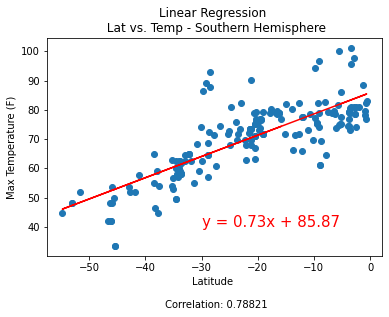

In [164]:
# Grab all Southern Hemisphere Data to work with
southern_hem_df = weather_df.loc[weather_df["Lat"] < 0]

# Set Southern Hemisphere (SH) Variables
sh_temp = southern_hem_df["Max Temperature"]
sh_lat = southern_hem_df["Lat"]

# Calc Linear Regression for SH
(slope, intercept, rvalue, pvalue, stderr) = linregress(sh_lat, sh_temp)
sh_temp_lat_regress_values = sh_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Create Scatter and label axes and title accordingly
plt.scatter(sh_lat,sh_temp)
plt.title("Linear Regression \n Lat vs. Temp - Southern Hemisphere")
plt.ylabel("Max Temperature (F)")
plt.xlabel(f"Latitude \n \n Correlation: {round(sh_temp_lat_co, 5)}")

# Plot and Annotate Linear Regression
plt.plot(sh_lat,sh_temp_lat_regress_values,"r-")
plt.annotate(line_eq,(-30,40),fontsize=15,color="red")

# Calc and Print correlation
sh_temp_lat_co = sci.pearsonr(sh_lat, sh_temp)[0]
print(f"The correlation (r) of temperature to latitude for the Southern Hemisphere is: {sh_temp_lat_co}.")

# Save Figure
plt.savefig("../output_data/linreg_SH_temp_vs_lat_fig.jpeg")

#### Observations: Linear Regression, Lat vs. Temp Southern Hemisphere

There is a strong, positive correlation between temperature and latitude: As latitude increases toward 0, temperature increases. 

##  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation (r) of humidity to latitude is: 0.40797908019798235.


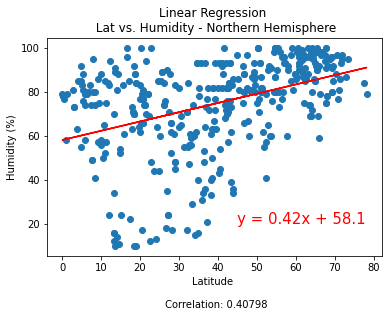

In [165]:
# Northern Hemisphere: northern_hem_df

# Set Northern Humidity Variable
nh_humidity = northern_hem_df["Humidity"]

# Use the Northern Hemisphere varibale
nh_lat = northern_hem_df["Lat"]

# Find Regression and write string for annotation
(slope, intercept, rvalue, pvalue, stderr) = linregress(nh_lat, nh_humidity)
nh_humid_lat_regress_values = nh_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot and name axes/title
plt.scatter(nh_lat,nh_humidity)
plt.title("Linear Regression \n Lat vs. Humidity - Northern Hemisphere")
plt.ylabel("Humidity (%)")
plt.xlabel(f"Latitude \n \n Correlation: {round(nh_humid_lat_co, 5)}")
plt.plot(nh_lat,nh_humid_lat_regress_values,"r-")
plt.annotate(line_eq,(45,20),fontsize=15,color="red")

# Find correlation, if there is any, print to screen
nh_humid_lat_co = sci.pearsonr(nh_lat, nh_humidity)[0]
print(f"The correlation (r) of humidity to latitude is: {nh_humid_lat_co}.")

# Export JPEG
plt.savefig("../output_data/linreg_NH_humid_vs_lat_fig.jpeg")

#### Obervations: Humidity vs. Lat - Northern Hemisphere

There does seem to be some correlation between humidity and latitude for this data set. However, this could be due to weather patterns. The correlation is weak. 

##  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation (r) of humidity to latitude is: 0.07426681172211337.


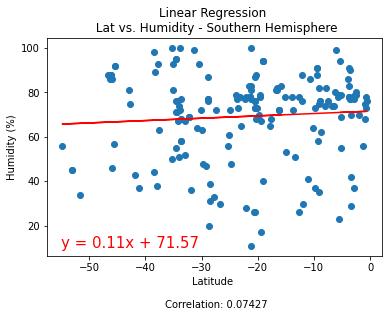

In [166]:
# Northern Hemisphere: northern_hem_df
# Southern Hemisphere: southern_hem_df

# Set Northern Humidity Variable
sh_humidity = southern_hem_df["Humidity"]

# Use the Northern Hemisphere varibale
sh_lat = southern_hem_df["Lat"]

# Find Regression and write string for annotation
(slope, intercept, rvalue, pvalue, stderr) = linregress(sh_lat, sh_humidity)
sh_humid_lat_regress_values = sh_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot and name axes/title
plt.scatter(sh_lat, sh_humidity)
plt.title("Linear Regression \n Lat vs. Humidity - Southern Hemisphere")
plt.ylabel("Humidity (%)")
plt.xlabel(f"Latitude \n \n Correlation: {round(sh_humid_lat_co, 5)}")
plt.plot(sh_lat,sh_humid_lat_regress_values,"r-")
plt.annotate(line_eq,(-55,10),fontsize=15,color="red")

# Find correlation, if there is any
sh_humid_lat_co = sci.pearsonr(sh_lat, sh_humidity)[0]
print(f"The correlation (r) of humidity to latitude is: {sh_humid_lat_co}.")
plt.savefig("../output_data/linreg_SH_humid_vs_lat_fig.jpeg")

#### Observations: Humidity and Latitude - Sothern Hemisphere

There is no correlation among this data. 

## Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation (r) of cloudiness to latitude is: 0.2971186138337021.


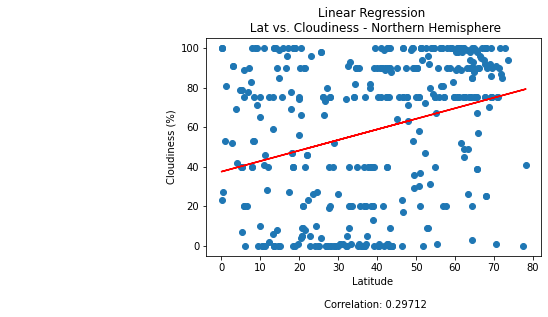

In [167]:
# Northern Hemisphere: northern_hem_df

# Set Northern Humidity Variable
nh_cloudiness = northern_hem_df["Cloudiness"]

# Use the Northern Hemisphere varibale
nh_lat = northern_hem_df["Lat"]

# Find Regression and write string for annotation
(slope, intercept, rvalue, pvalue, stderr) = linregress(nh_lat, nh_cloudiness)
nh_cloud_lat_regress_values = nh_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot and name axes/title
plt.scatter(nh_lat, nh_cloudiness)
plt.title("Linear Regression \n Lat vs. Cloudiness - Northern Hemisphere")
plt.ylabel("Cloudiness (%)")
plt.xlabel(f"Latitude \n \n Correlation: {round(nh_cloud_lat_co, 5)}")
plt.plot(nh_lat,nh_cloud_lat_regress_values,"r-")
plt.annotate(line_eq,(-55,10),fontsize=15,color="red")

# Find correlation, if there is any
nh_cloud_lat_co = sci.pearsonr(nh_lat, nh_cloudiness)[0]
print(f"The correlation (r) of cloudiness to latitude is: {nh_cloud_lat_co}.")

# Export JPEG
plt.savefig("../output_data/linreg_NH_cloud_vs_lat_fig.jpeg")

#### Observations: Cloudiness and Latitude - Northern Hemisphere

There is almost a weak correlation; however, again, any correlation could be the result of storm systems. Since (r) is less than .30, there is technically no correlation. 

##  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation (r) of cloudiness to latitude is: 0.07171036937854329.


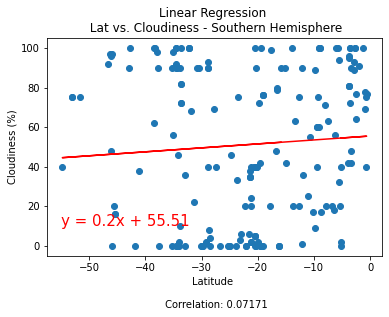

In [168]:
# Southern Hemisphere: southern_hem_df

# Set Southern Humidity Variable
sh_cloudiness = southern_hem_df["Cloudiness"]

# Use the Southern Hemisphere varibale
sh_lat = southern_hem_df["Lat"]

# Find Regression and write string for annotation
(slope, intercept, rvalue, pvalue, stderr) = linregress(sh_lat, sh_cloudiness)
sh_cloud_lat_regress_values = sh_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot and name axes/title
plt.scatter(sh_lat, sh_cloudiness)
plt.title("Linear Regression \n Lat vs. Cloudiness - Southern Hemisphere")
plt.ylabel("Cloudiness (%)")
plt.xlabel(f"Latitude \n \n Correlation: {round(sh_cloud_lat_co, 5)}")
plt.plot(sh_lat,sh_cloud_lat_regress_values,"r-")
plt.annotate(line_eq,(-55,10),fontsize=15,color="red")

# Find correlation, if there is any
sh_cloud_lat_co = sci.pearsonr(sh_lat, sh_cloudiness)[0]
print(f"The correlation (r) of cloudiness to latitude is: {sh_cloud_lat_co}.")

# Export JPEG
plt.savefig("../output_data/linreg_SH_cloud_vs_lat_fig.jpeg")

#### Observations: Cloudiness and Latitude - Southern Hemisphere

There is no correlation between cloudiness and latitude in the southern hemisphere. 

##  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation (r) of windspeed to latitude is: -0.007615036468511447.


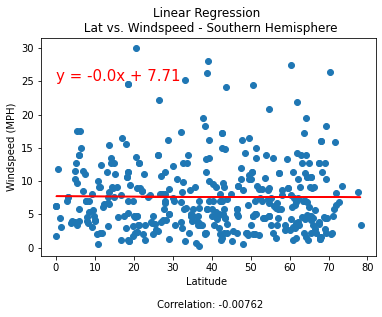

In [169]:
# Northern Hemisphere DataFrame: northern_hem_df

# Set Northern Windspeed Variable
nh_windspeed = northern_hem_df["Windspeed"]

# Use the Southern Hemisphere varibale
nh_lat = northern_hem_df["Lat"]

# Find Regression and write string for annotation
(slope, intercept, rvalue, pvalue, stderr) = linregress(nh_lat, nh_windspeed)
nh_wind_lat_regress_values = nh_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot and name axes/title
plt.scatter(nh_lat, nh_windspeed)
plt.title("Linear Regression \n Lat vs. Windspeed - Southern Hemisphere")
plt.ylabel("Windspeed (MPH)")
plt.xlabel(f"Latitude \n \n Correlation: {round(nh_wind_lat_co, 5)}")
plt.plot(nh_lat,nh_wind_lat_regress_values,"r-")
plt.annotate(line_eq,(0,25),fontsize=15,color="red")

# Find correlation, if there is any
nh_wind_lat_co = sci.pearsonr(nh_lat, nh_windspeed)[0]
print(f"The correlation (r) of windspeed to latitude is: {nh_wind_lat_co}.")

# Export JPEG
plt.savefig("../output_data/linreg_NH_wind_vs_lat_fig.jpeg")

#### Observations: Wind Speed and Latitude - Northern Hemisphere

There is no correlation between wind speed and latitude in the northern hemisphere.

##  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation (r) of Wind Speed to latitude is: -0.23423507078641392.


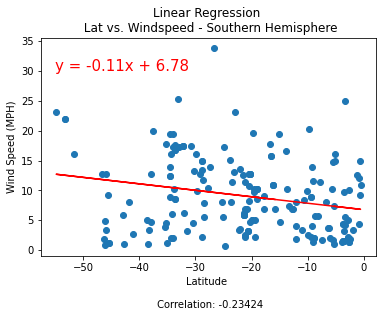

In [170]:
# Southern Hemisphere: southern_hem_df

# Set Southern Humidity Variable
sh_windspeed = southern_hem_df["Windspeed"]

# Use the Southern Hemisphere varibale
sh_lat = southern_hem_df["Lat"]

# Find Regression and write string for annotation
(slope, intercept, rvalue, pvalue, stderr) = linregress(sh_lat, sh_windspeed)
sh_wind_lat_regress_values = sh_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot and name axes/title
plt.scatter(sh_lat, sh_windspeed)
plt.title("Linear Regression \n Lat vs. Windspeed - Southern Hemisphere")
plt.ylabel("Wind Speed (MPH)")
plt.xlabel(f"Latitude \n \n Correlation: {round(sh_wind_lat_co, 5)}")
plt.plot(sh_lat,sh_wind_lat_regress_values,"r-")
plt.annotate(line_eq,(-55,30),fontsize=15,color="red")

# Find correlation, if there is any
sh_wind_lat_co = sci.pearsonr(sh_lat, sh_windspeed)[0]
print(f"The correlation (r) of Wind Speed to latitude is: {sh_wind_lat_co}.")

# Export JPEG
plt.savefig("../output_data/linreg_SH_wind_vs_lat_fig.jpeg")

#### Observations: Wind Speed and Latitude - Southern Hemisphere

There is no correlation between wind speed and latitude in the southern hemisphere. 